# Playlist classification - Introduction
This notebook is a third and the last part of [eargasm-spotify](https://github.com/adamsiemaszkiewicz/eargasm-music) repository. The goal of this part is to build a multiclass classification model to predict which playlist the track belongs to. The attempt is strictly experimental because of the nature of how those playlists are made in the first place. It is most of the time strictly subjective and susceptible to personal biases and tiny musial nuances.

There are 29 playlists and 3621 unique songs in the dataset. Some of the tracks are assigned to more than one playlist and the track representation for each playlist is inbalanced, meaning some playlist have over 200 songs, other around 50 which makes things even harder. Nevertheless, let's give it a try :)

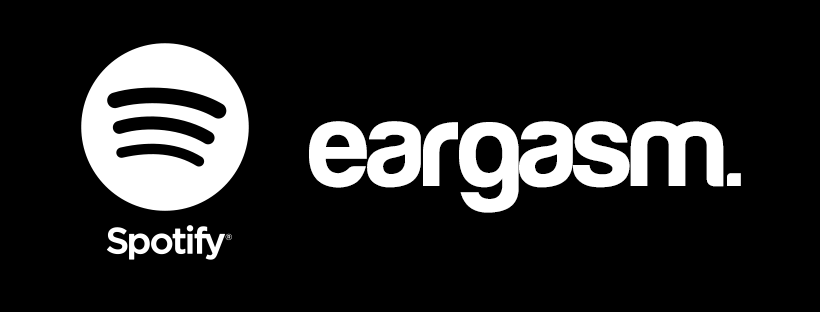

# Set up environment

## Google Drive mount
I'm using Google Colaboratory as my default platform, therefore I need to set up my environment to integrate it with Google Drive. You can skip this bit if you're working locally.

1. Mount Google Drive on the runtime to be able to read and write files. This will ask you to log in to your Google Account and provide an authorization code.
2. Change the directory to the one where I cloned my repository.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
%cd /content/gdrive/My Drive/Colab Notebooks/eargasm-music/

/content/gdrive/My Drive/Colab Notebooks/eargasm-music


## Import libraries and functions
Let's import all the libraries and function we're gonna use throughout the notebook.

### Notebook
- `tqdm.notebook` `tqdm` - Progress bars
- `timeit` - Measure execution time of small code snippets

In [ ]:
from tqdm.notebook import tqdm
import timeit

### Data science
- `pandas` - data manipulation & analysis
- `pd.options.mode.chained_assignment` - switch off warning for chained_assignment
- `numpy` - linear algebra

In [ ]:
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np

### Visualization
- `matplotlib.pyplot` - basic visualizations
- `plotly` - advanced visualizations
- `plotly.express` - fast vizualizations
- `plotly.graph_objects` - more control over plotly figures

In [60]:
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import plotly
import plotly.express as px
import plotly.graph_objects as go

## Machine learning
For this task I'll use [Scikit-learn](https://scikit-learn.org/) Python machine learning library. 

In [ ]:
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, learning_curve
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.inspection import partial_dependence, plot_partial_dependence

# estimators
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis, LinearDiscriminantAnalysis



# Feature engineering

# Load data
Let's load the data fetched from the [Eargasm Music](https://open.spotify.com/user/eargasmusic?si=cz4VzEi1RgaUup_g8-UnEg) Spotify channel using `eargasm_retrieve-data.ipynb`. The data set consists of the tracks with their features as well as a playlist name label.

In [ ]:
final_df = pd.read_csv('files/final_df.csv', index_col=0)
final_df['track_playlist'] = final_df['track_playlist'].apply(lambda x: x.split(' | ')[1])
final_df.head()

,track_id,track_artist,track_artistid,track_name,track_duration,track_popularity,track_releasedate,track_preview,track_image,track_url,track_playlist,track_genre,acousticness,danceability,energy,instrumentalness,liveness,speechiness,valence,key,key_confidence,mode,mode_confidence,number_of_sections,tempo,tempo_confidence,time_signature,time_signature_confidence
0,1ua6hBq18qZLyprXjMcpyf,Virgil Howe,6d3Hil7Y1xq0oEhtaDxEUg,Someday,251266,41,2009-10-19,https://p.scdn.co/mp3-preview/a2bdcba6acda937f...,https://i.scdn.co/image/ab67616d0000b27356dc5e...,https://open.spotify.com/track/1ua6hBq18qZLypr...,breathe easy,NaN,0.370,0.483,0.462,0.210000,0.0875,0.0290,0.351,9.0,0.292,0.0,0.398,12.0,86.502,0.160,4.0,1.000
1,42VpxSdGQgnV1UJkWeGYkA,Cass McCombs,2iUVQjheBnvOt8vaBrxXJz,Switch,254233,51,2016-08-26,https://p.scdn.co/mp3-preview/d0feea85b84ce9f5...,https://i.scdn.co/image/ab67616d0000b27396782c...,https://open.spotify.com/track/42VpxSdGQgnV1UJ...,breathe easy,alternative country,0.362,0.682,0.538,0.000123,0.3240,0.0283,0.713,7.0,0.743,0.0,0.453,12.0,98.003,0.583,4.0,1.000
2,1g8A166soQjwl1ihqBWKGW,The Slow Revolt,7cfCmW2AFiMNdpJdY0vJsr,Lean,207699,0,2016-09-09,NaN,https://i.scdn.co/image/ab67616d0000b273ce48d6...,https://open.spotify.com/track/1g8A166soQjwl1i...,breathe easy,vapor pop,0.195,0.536,0.753,0.801000,0.1200,0.0309,0.676,1.0,0.655,1.0,0.368,12.0,85.036,0.325,4.0,0.979
3,6cAVWcj8TQ5yR2T6BZjnOg,Dirty Nice,4MGA6AM4iZ2HYc6b77og9g,Zero Summer,212640,0,2017-06-09,NaN,https://i.scdn.co/image/ab67616d0000b2733a028c...,https://open.spotify.com/track/6cAVWcj8TQ5yR2T...,breathe easy,NaN,0.742,0.663,0.509,0.000006,0.1120,0.0889,0.303,11.0,0.547,1.0,0.560,12.0,125.088,0.476,4.0,0.845
4,3YA509E9ki7a3Ic9cf25Vt,Alex Ebert,1me05HW5s7TShHra5nN7uE,Broken Record,274800,47,2017-05-05,https://p.scdn.co/mp3-preview/96c62ba3b9d730d3...,https://i.scdn.co/image/ab67616d0000b2738a6904...,https://open.spotify.com/track/3YA509E9ki7a3Ic...,breathe easy,alternative americana,0.240,0.464,0.570,0.001210,0.1380,0.0400,0.548,0.0,0.905,1.0,0.753,12.0,170.556,0.183,4.0,0.799


## Select features
After data exploration in the previous notebook I know that not all features will be useful for model-building therefore I'll drop them. Some features might seem not correct to get rid of so let me explain:
- `track_artist` - due to large number of artists the feature would slow the algorithm down; also, knowing the dataset, it doesn't seem to be a good clue for an algorithm
- `track_populariy` - there's a lot of zeroes in this feature; additionally the mean of the feature is roughly the same regardless of the playlist
- `track_genre` - similarily to `track_artist` there's too many different genres, which would slow down the process; additionally there's a lot of similar tags and it's just doesn't seem to be helpful anyhow
- `mode` - no correlation with the playlists
- `key` - no correlation with the playlists
- `time_signature` - no correlation with the playlists

In [ ]:
features_to_keep = [
                    'track_duration',
                    'acousticness',
                    'danceability',
                    'energy',
                    'instrumentalness',
                    'liveness',
                    'speechiness',
                    'valence',
                    'tempo',
                    'track_playlist'
                  ]
df_encoded = final_df[features_to_keep]


## Features encoding
I'll set up some functions not to repeat some of the activities later on.

1. `cut_into_categories()` - Takes the DataFrame, selects one feature column with continuous values and returns a DataFrame with those values cut into ordinal categories.
2. `fill_nans()` Fills missing values in a feature column.

***Disclaimer:*** *Later on the method which takes advantage of the `cut_into_categories()` function turned out not to help with the estimator of choice, so I commented most of it out.*

In [ ]:
def cut_into_categories(feature_name, number_of_categories):
  '''
  Take the values of an ordinal feature, cut the values into a particular number of ranges and return a DataFrame 
  '''

  df_encoded[feature_name] = final_df[feature_name]  
  df_encoded[feature_name] = pd.cut(df_encoded[feature_name], number_of_categories)

  ranges = df_encoded[feature_name].unique()
  ranges.sort_values(inplace=True)

  for n, value in enumerate(ranges):
    df_encoded.loc[df_encoded[feature_name] == value, feature_name+'_en'] = n+1

  df_encoded.drop(columns=[feature_name], inplace=True)
  df_encoded.rename(columns = {feature_name+'_en': feature_name}, inplace = True)

  return df_encoded

In [ ]:
def fill_nans(feature_name):
  df_encoded[feature_name].fillna(int(df_encoded[feature_name].mean()), inplace=True)
  return df_encoded

In [ ]:
# df_encoded['track_duration'] = final_df['track_duration'] # reset value
# df_encoded['track_duration'] = df_encoded['track_duration'].apply(lambda x: x/60000)

# cut_into_categories('track_duration', 10)
# cut_into_categories('track_popularity', 10)
# cut_into_categories('acousticness', 10)
# cut_into_categories('danceability', 10)
# cut_into_categories('energy', 10)
# cut_into_categories('instrumentalness', 10)
# cut_into_categories('liveness', 10)
# cut_into_categories('speechiness', 10)
# cut_into_categories('valence', 10)
# cut_into_categories('tempo', 15)

# # df_encoded['track_genre'].fillna('unknown', inplace=True)
# df_encoded['tempo'].fillna(int(df_encoded['tempo'].mean()), inplace=True)


# # fill_nans('key')
# # fill_nans('mode')
# # fill_nans('time_signature')

# df_encoded = df_encoded.dropna()
# df_encoded.head()

fill_nans('tempo')
df_encoded.head()

,track_duration,acousticness,danceability,energy,instrumentalness,liveness,speechiness,valence,tempo,track_playlist
0,251266,0.370,0.483,0.462,0.210000,0.0875,0.0290,0.351,86.502,breathe easy
1,254233,0.362,0.682,0.538,0.000123,0.3240,0.0283,0.713,98.003,breathe easy
2,207699,0.195,0.536,0.753,0.801000,0.1200,0.0309,0.676,85.036,breathe easy
3,212640,0.742,0.663,0.509,0.000006,0.1120,0.0889,0.303,125.088,breathe easy
4,274800,0.240,0.464,0.570,0.001210,0.1380,0.0400,0.548,170.556,breathe easy


# Multiclass classification

## Train/test split
First let's split our dataset into training and test sets. I'll use train set for training and model development and test set for model evaluation and final testing. I'll use scikit-learn's `train_test_split()` method for this task.

In [ ]:
X = df_encoded.drop(columns=['track_playlist'])
y = df_encoded['track_playlist']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

## Model selection
Let's use a list of commonly used classifiers and run them with default setting to see how well they perform in terms of accuracy and runtime. After iterating through them, I'll choose three or four best performing ones and try to evaluate them further in order to find a right one. To do so, for each classifier I will:
1. Construct a pipeline of two steps:
 - `StandardScaler()` to standardize features by removing the mean and scaling to unit variance
 - and a classifier.
2. Fit the pipeline using train set and check its runtime for later reference.
3. For each classifier save some scores:
 - training set accuracy
 - test set accuracy
 - mean cross-validation score
 - runtime
4. Sort the results by the value of cross-validation score.
5. Select four best-performing estimators for further development. 

In [ ]:
list_of_classifiers = [
                       LogisticRegression(),
                       KNeighborsClassifier(),
                       SVC(),
                       DecisionTreeClassifier(),
                       MLPClassifier(),
                       RandomForestClassifier(),
                       AdaBoostClassifier(),
                       GaussianNB(),
                       QuadraticDiscriminantAnalysis(),
                       LinearDiscriminantAnalysis()
                      ]

In [ ]:
classifiers = pd.DataFrame()

for classifier in tqdm(list_of_classifiers):
  
  clf = make_pipeline(StandardScaler(), classifier)

  start = timeit.default_timer()
  clf.fit(X_train, y_train)
  stop = timeit.default_timer()

  name = str(classifier).split('(')[0]
  train_score = clf.score(X_train, y_train)
  test_score = clf.score(X_test, y_test)
  score_cv = cross_val_score(clf, X_train, y_train, cv=5, scoring='accuracy').mean()
  runtime = stop-start


  classifiers = classifiers.append(
      {'classifier': name,
       'score_train': train_score,
       'score_test': test_score,
       'score_cv': score_cv,
       'runtime': runtime
      },
      ignore_index = True)

classifiers.sort_values(by='score_cv', ascending=False)

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iter

,classifier,runtime,score_cv,score_test,score_train
0,LogisticRegression,0.651777,0.195580,0.208609,0.216206
9,LinearDiscriminantAnalysis,0.021701,0.195212,0.189845,0.209208
2,SVC,0.524109,0.193002,0.197572,0.288766
7,GaussianNB,0.017688,0.172744,0.173289,0.193738
4,MLPClassifier,5.255566,0.170534,0.185430,0.299079
8,QuadraticDiscriminantAnalysis,0.018280,0.155433,0.173289,0.216943
5,RandomForestClassifier,1.398728,0.132597,0.125828,0.724125
6,AdaBoostClassifier,0.680398,0.123389,0.128035,0.131492
1,KNeighborsClassifier,0.016140,0.123020,0.115894,0.349908
3,DecisionTreeClassifier,0.054975,0.077716,0.064018,0.724125


## Hyperparameter tuning
Let's define two functions to help us with hyperparameter tuning and evaluation of the models.

1. `model_evaluation()` performs an exhaustive search over parameters for an estimator to find a best-performing combination of parameters for a particular estimator. The function returns:
 - model fitting runtime
 - best score value
 - best parameters
 - best estimator
 - score values for train and test sets
 - cross validation score value
2. `confusion_matrix_plot()` plots the confusion matrix for a particular estimator to evalue the accuracy of a classification
3. `plot_learning_curve()` generates three plots to help to understand potential issues with the model:
 - the test and training learning curves
 - the training samples vs fit times curve
 - the fit times vs score curve

In [ ]:
def model_evaluation(estimator, parameters):
  pipe = make_pipeline(StandardScaler(), estimator)
  parameters = parameters

  search = GridSearchCV(pipe, parameters, n_jobs=-1)
  start = timeit.default_timer()
  search.fit(X_train, y_train)
  stop = timeit.default_timer()

  b_score = search.best_score_
  b_parameters = search.best_params_
  b_estimator = search.best_estimator_
  score_train = b_estimator.score(X_train, y_train)
  score_test = b_estimator.score(X_test, y_test)
  score_cv = cross_val_score(search, X_train, y_train, cv=5, scoring='accuracy').mean()
  runtime = stop-start

  evaluation_results = dict(runtime=runtime,
                            b_score=b_score,
                            b_parameters=b_parameters,
                            b_estimator=b_estimator,
                            score_test=train_score,
                            score_train=score_train,
                            score_cv=score_cv
                           )

  return evaluation_results

In [ ]:
def confusion_matrix_plot(classifier):
  fig, (ax1, ax2) = plt.subplots(nrows=1,
                           ncols=2,
                           sharex=True,
                           sharey=True,
                           figsize=(20,10))
  plot_confusion_matrix(classifier, X_train, y_train, ax=ax1)
  plot_confusion_matrix(classifier, X_test, y_test, ax=ax2)

  plt.xticks(rotation=90) 
  ax1.set(title='Train set')
  ax1.tick_params(axis='x', labelrotation=90)
  ax2.set(title='Test set') 
  ax2.tick_params(axis='x', labelrotation=90)

  return plt.show()

In [ ]:
def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    axes : array of 3 axes, optional (default=None)
        Axes to use for plotting the curves.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:

          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt

### Logistic Regression


In [ ]:
start = timeit.default_timer()

parameters = {
              'logisticregression__C': [100, 10, 1.0, 0.1, 0.01],
              'logisticregression__penalty': ['l1', 'l2'],
              'logisticregression__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
             }
logreg_evaluation_results = model_evaluation(LogisticRegression(class_weight='balanced', # Cost-Sensitive Logistic Regression
                                                         multi_class='ovr',
                                                         n_jobs=-1), parameters)

stop = timeit.default_timer()
print('Runtime: {} seconds.'.format(stop-start))

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:1539: UserWarning:

'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.



Runtime: 420.344060633 seconds.


In [ ]:
logreg_evaluation_results

{'b_estimator': Pipeline(memory=None,
          steps=[('standardscaler',
                  StandardScaler(copy=True, with_mean=True, with_std=True)),
                 ('logisticregression',
                  LogisticRegression(C=0.01, class_weight='balanced', dual=False,
                                     fit_intercept=True, intercept_scaling=1,
                                     l1_ratio=None, max_iter=100,
                                     multi_class='ovr', n_jobs=-1, penalty='l2',
                                     random_state=None, solver='newton-cg',
                                     tol=0.0001, verbose=0, warm_start=False))],
          verbose=False),
 'b_parameters': {'logisticregression__C': 0.01,
  'logisticregression__penalty': 'l2',
  'logisticregression__solver': 'newton-cg'},
 'b_score': 0.1686924493554328,
 'runtime': 81.16765327200005,
 'score_cv': 0.16574585635359118,
 'score_test': 0.20920810313075505,
 'score_train': 0.17495395948434622}

In [ ]:
logreg = logreg_evaluation_results['b_estimator']

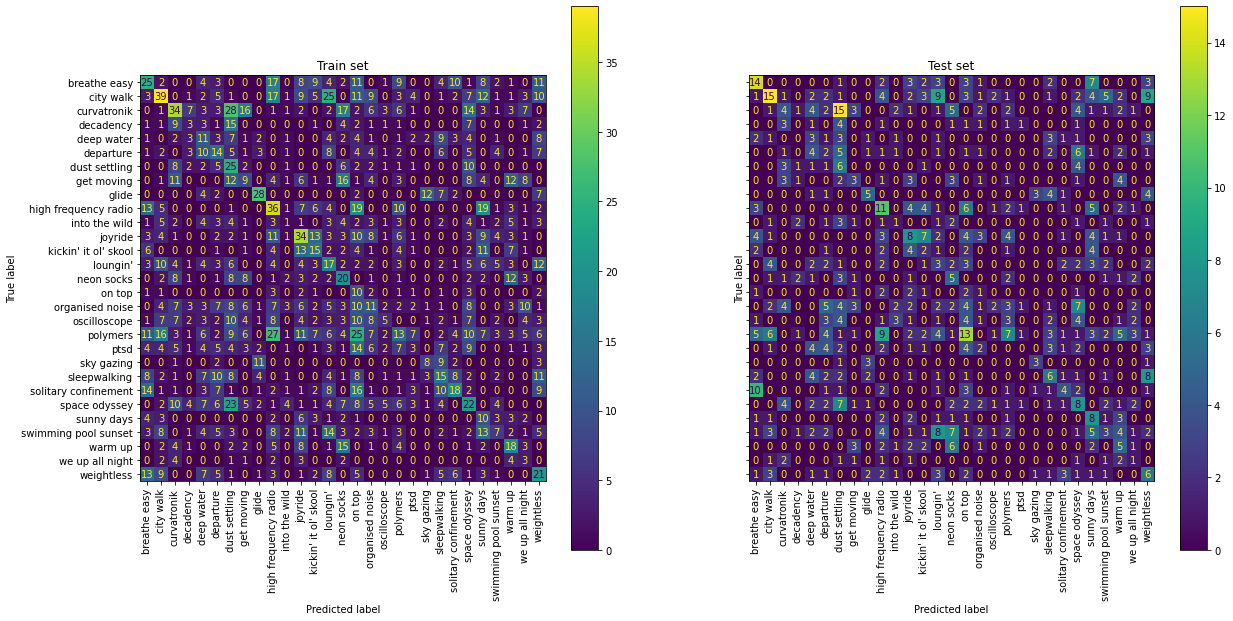

In [ ]:
confusion_matrix_plot(logreg)

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

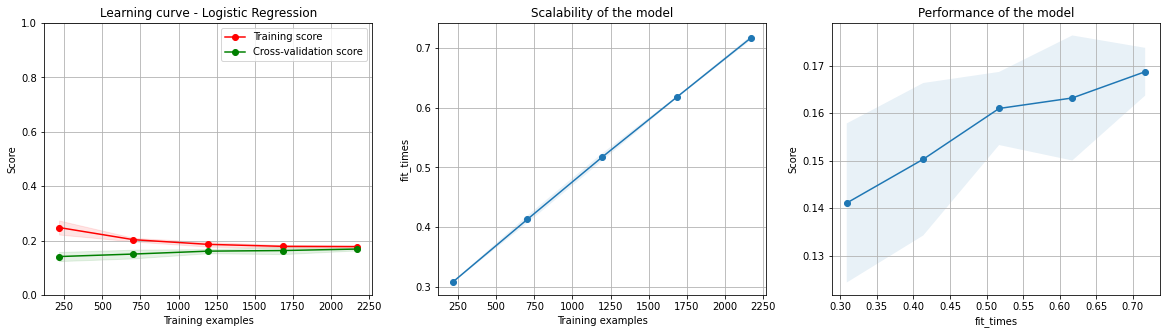

In [ ]:
plot_learning_curve(
                    logreg,
                    title='Learning curve - Logistic Regression',
                    X=X_train,
                    y=y_train,
                    ylim=(0.0, 1.0),
                    cv=5,
                    n_jobs=-1,
                    train_sizes=np.linspace(.1, 1.0, 5)
                   )

### Linear Discriminant Analysis

In [ ]:
start = timeit.default_timer()

parameters = {
              'lineardiscriminantanalysis__solver': ['svd', 'lsqr', 'eigen'],
              'lineardiscriminantanalysis__shrinkage': [None, 'auto']
             }
lda_evaluation_results = model_evaluation(LinearDiscriminantAnalysis(), parameters)

stop = timeit.default_timer()
print('Runtime: {} seconds.'.format(stop-start))

Runtime: 3.966263194000021 seconds.


In [ ]:
lda_evaluation_results

{'b_estimator': Pipeline(memory=None,
          steps=[('standardscaler',
                  StandardScaler(copy=True, with_mean=True, with_std=True)),
                 ('lineardiscriminantanalysis',
                  LinearDiscriminantAnalysis(n_components=None, priors=None,
                                             shrinkage=None, solver='svd',
                                             store_covariance=False,
                                             tol=0.0001))],
          verbose=False),
 'b_parameters': {'lineardiscriminantanalysis__shrinkage': None,
  'lineardiscriminantanalysis__solver': 'svd'},
 'b_score': 0.19521178637200737,
 'runtime': 0.7043851500000073,
 'score_cv': 0.19152854511970535,
 'score_test': 0.20920810313075505,
 'score_train': 0.20920810313075505}

In [ ]:
lda = lda_evaluation_results['b_estimator']

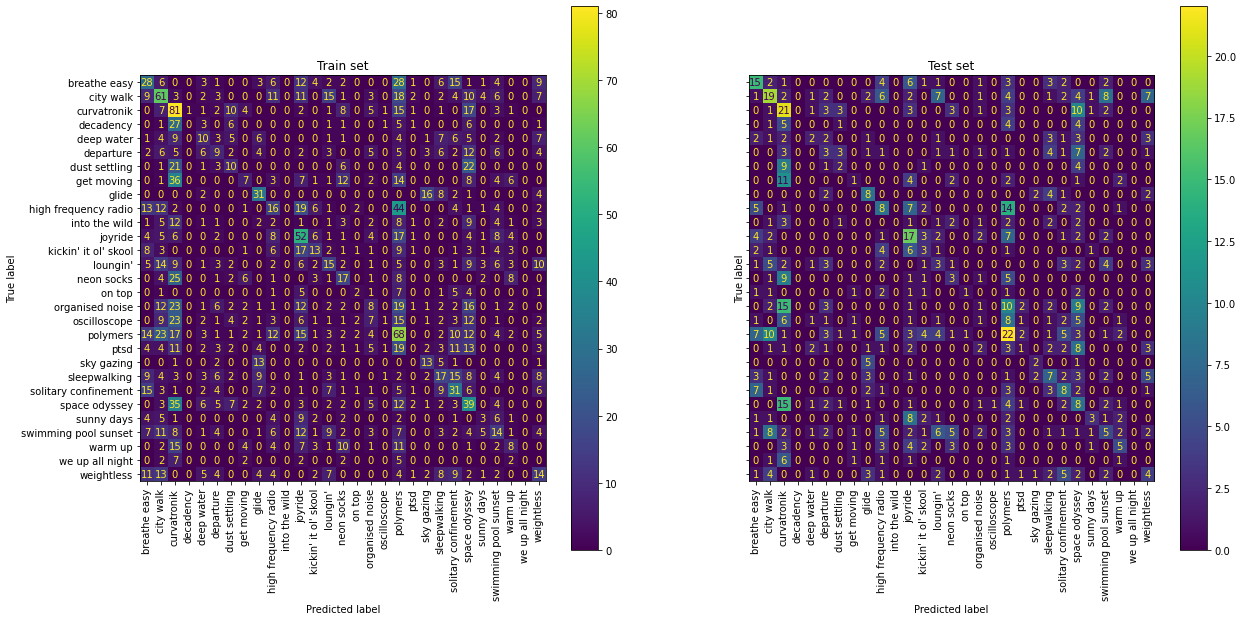

In [ ]:
confusion_matrix_plot(lda)

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

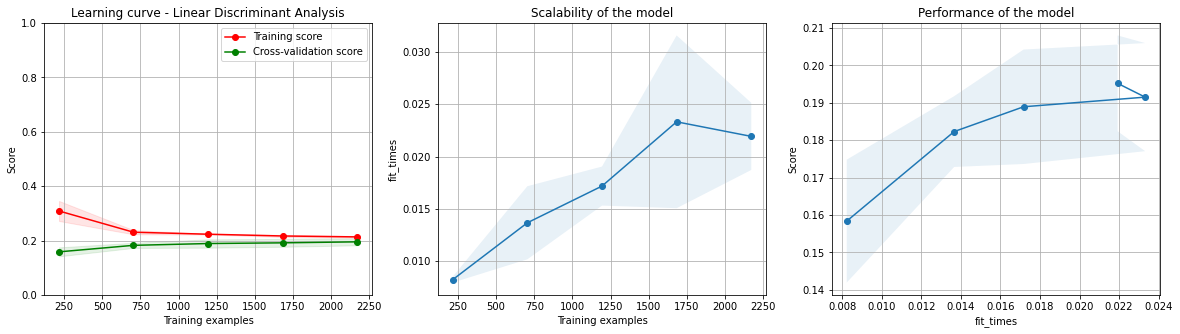

In [ ]:
plot_learning_curve(
                    lda,
                    title='Learning curve - Linear Discriminant Analysis',
                    X=X_train,
                    y=y_train,
                    ylim=(0.0, 1.0),
                    cv=5,
                    n_jobs=-1,
                    train_sizes=np.linspace(.1, 1.0, 5)
                   )

### Support Vector Classifier

In [ ]:
start = timeit.default_timer()

parameters = {
              'svc__C': [1, 3, 6],
              'svc__kernel': ['linear', 'poly', 'rbf'],
              'svc__degree': [1, 2, 3]
             }
svc_evaluation_results = model_evaluation(SVC(probability=True, decision_function_shape='ovo'), parameters)

stop = timeit.default_timer()
print('Runtime: {} seconds.'.format(stop-start))

Runtime: 1029.9885384919999 seconds.


In [ ]:
svc_evaluation_results

{'b_estimator': Pipeline(memory=None,
          steps=[('standardscaler',
                  StandardScaler(copy=True, with_mean=True, with_std=True)),
                 ('svc',
                  SVC(C=6, break_ties=False, cache_size=200, class_weight=None,
                      coef0=0.0, decision_function_shape='ovo', degree=1,
                      gamma='scale', kernel='poly', max_iter=-1,
                      probability=True, random_state=None, shrinking=True,
                      tol=0.001, verbose=False))],
          verbose=False),
 'b_parameters': {'svc__C': 6, 'svc__degree': 1, 'svc__kernel': 'poly'},
 'b_score': 0.19558011049723756,
 'runtime': 229.4029844490001,
 'score_cv': 0.19079189686924491,
 'score_test': 0.20920810313075505,
 'score_train': 0.2151012891344383}

In [ ]:
svc = svc_evaluation_results['b_estimator']

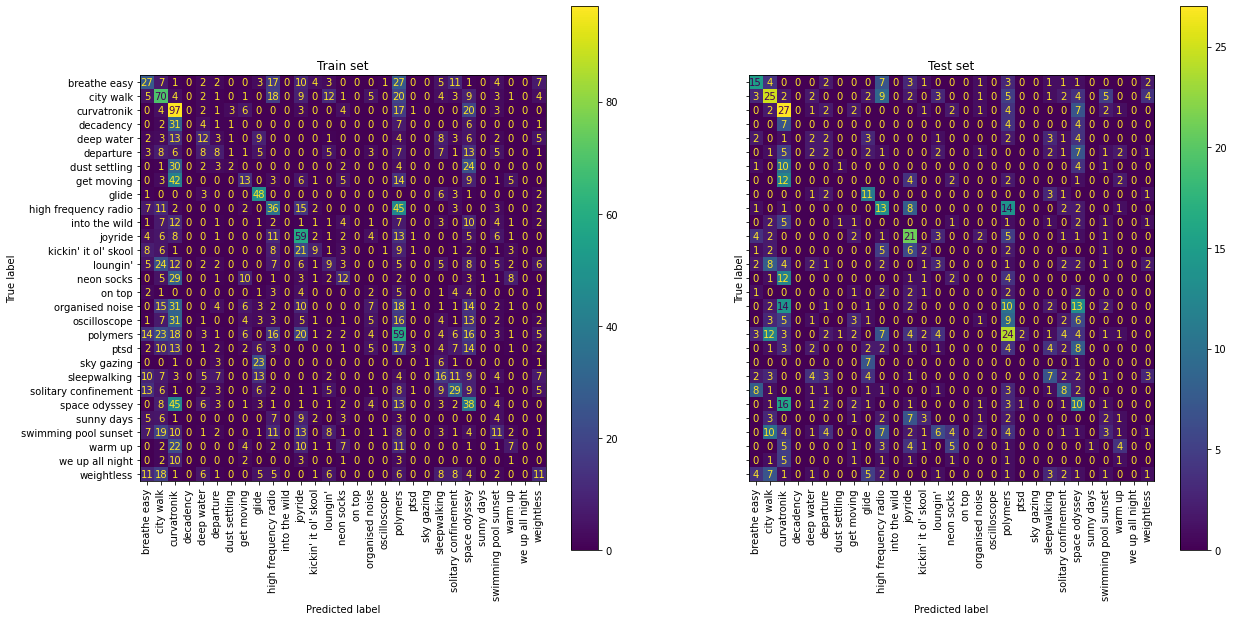

In [ ]:
confusion_matrix_plot(svc)

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

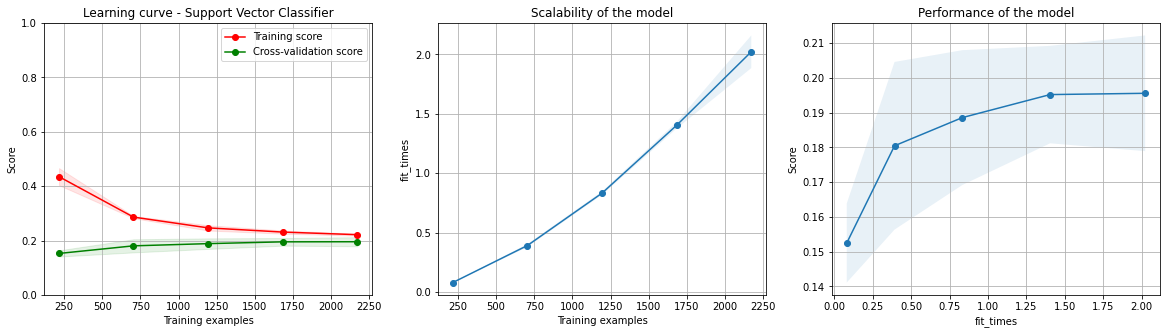

In [ ]:
plot_learning_curve(
                    svc,
                    title='Learning curve - Support Vector Classifier',
                    X=X_train,
                    y=y_train,
                    ylim=(0.0, 1.0),
                    cv=5,
                    n_jobs=-1,
                    train_sizes=np.linspace(.1, 1.0, 5)
                   )

### Random Forest Classifier

In [ ]:
start = timeit.default_timer()

parameters = {
              'randomforestclassifier__n_estimators': [1000],
              'randomforestclassifier__max_depth': [5],
              'randomforestclassifier__min_samples_leaf': [1,2,3]
             }
rfc_evaluation_results = model_evaluation(RandomForestClassifier(class_weight='balanced'), parameters)

stop = timeit.default_timer()
print('Runtime: {} seconds.'.format(stop-start))

Runtime: 331.1336265519999 seconds.


In [ ]:
rfc_evaluation_results

{'b_estimator': Pipeline(memory=None,
          steps=[('standardscaler',
                  StandardScaler(copy=True, with_mean=True, with_std=True)),
                 ('randomforestclassifier',
                  RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                         class_weight='balanced',
                                         criterion='gini', max_depth=5,
                                         max_features='auto',
                                         max_leaf_nodes=None, max_samples=None,
                                         min_impurity_decrease=0.0,
                                         min_impurity_split=None,
                                         min_samples_leaf=2, min_samples_split=2,
                                         min_weight_fraction_leaf=0.0,
                                         n_estimators=1000, n_jobs=None,
                                         oob_score=False, random_state=None,
                

In [ ]:
rfc = rfc_evaluation_results['b_estimator']

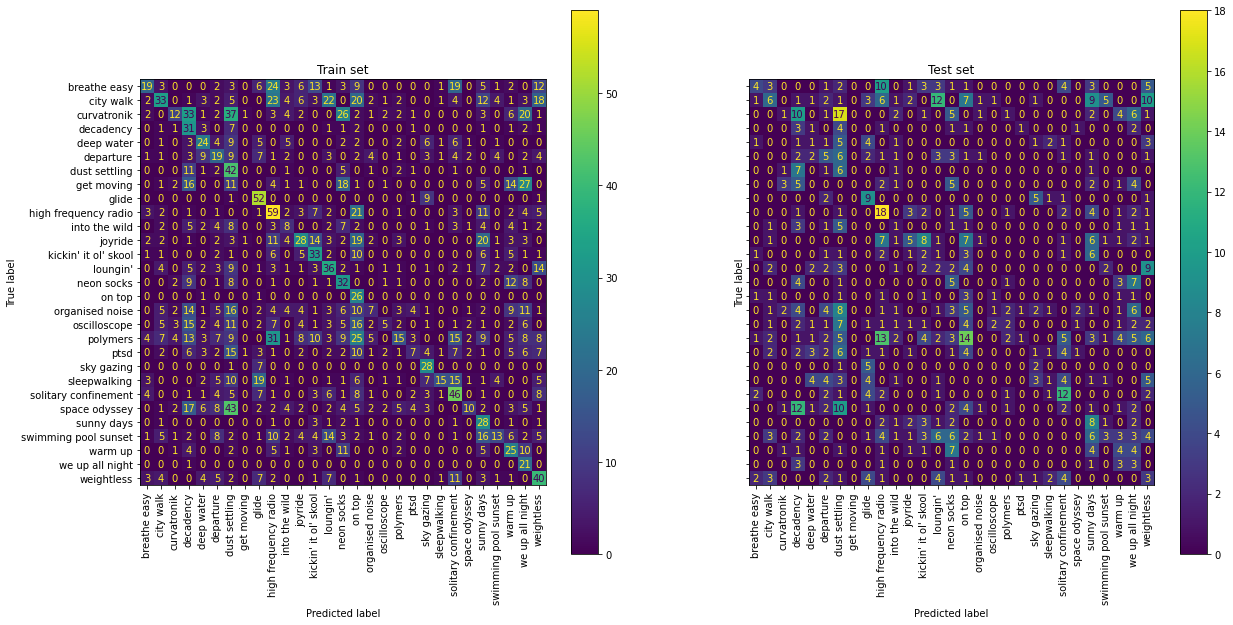

In [ ]:
confusion_matrix_plot(rfc)

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

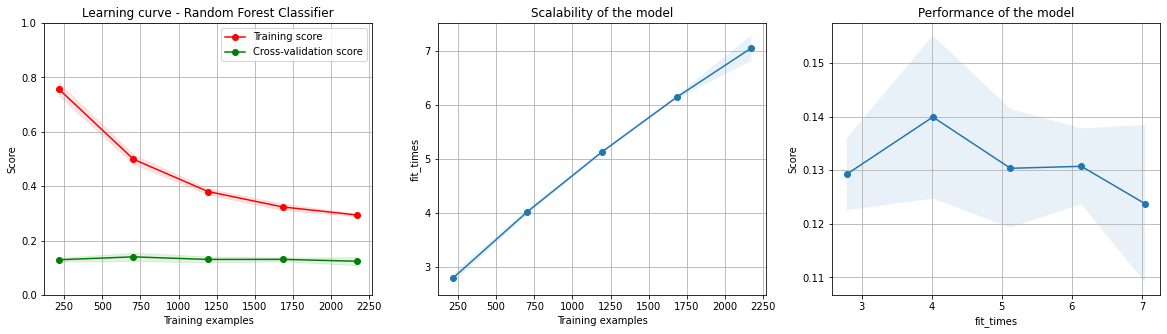

In [ ]:
plot_learning_curve(
                    rfc,
                    title='Learning curve - Random Forest Classifier',
                    X=X_train,
                    y=y_train,
                    ylim=(0.0, 1.0),
                    cv=5,
                    n_jobs=-1,
                    train_sizes=np.linspace(.1, 1.0, 5)
                   )

## Model selection & probability check
Based on the test performance it seems like Logistic Regression model, even though does not have the highest scores, manages to deal with inbalanced classes and generalization the best. Let's perform a real-world test on the fit model and visualize relation between predictions and grount truth on a basic bar chart.

In [64]:
def probabilities_plot(number):
  df = pd.DataFrame({'class': clf.classes_, 'probability': clf.predict_proba(X_test)[number]})
  df = df.sort_values(by='probability', ascending=False).head(10)

  index_number = X_test.index[number]
  prediction = print('{} - {}: {}'.format(final_df.loc[index_number]['track_artist'],
                               final_df.loc[index_number]['track_name'],
                               final_df.loc[index_number]['track_url']
                              )
                    )

  id = final_df.loc[index_number]['track_id']
  truth = final_df.loc[final_df['track_id'] == id]['track_playlist']

  colors = []

  for pred in list(df['class']):
    if pred in list(truth): colors.append('tab:green')
    else: colors.append('tab:gray')
  
  fig, ax = plt.subplots(figsize=(10,10))
  fig = plt.bar(df['class'], df['probability'], color=colors, label='Ground truth');
  plt.xticks(rotation=90);
  ax.set_ylabel('probability')
  ax.set_xlabel('playlist name')
  ax.set_title('Model predictions vs ground truth')
  legend_elements = [Patch(facecolor='tab:green', label='Ground truth')]

  ax.legend(handles=legend_elements)

  return prediction

Shakarchi & Stranéus - Marcy Son What: https://open.spotify.com/track/4Sp1D2xf63Y1QR572hW0He


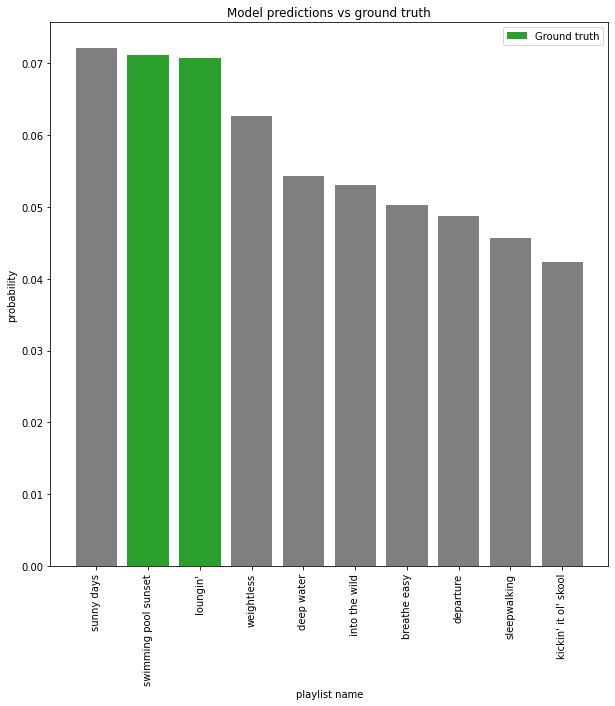

In [89]:
clf = logreg
random_number = np.random.randint(0, X_test.shape[0])
probabilities_plot(random_number)

# Final word
Even though the task seemed almost impossible to achieve due to a high subjectivity of the topic nor the scoring seems to be exceptionally low, it turns out that testing the model on the real world data brings surprisingly good results and will most probably improve with each new song in the database. 

**To be continued...**